## Capture `display()` output

In [ ]:
#| default_exp utils.capture_display

In [ ]:
#| export
from IPython.core.displaypub import DisplayPublisher
from IPython.core.display_functions import _new_id
from IPython.display import display, clear_output, Javascript
from IPython import get_ipython
from typing import List
from PIL import Image
from collections import defaultdict
import warnings
import sys
import re
import cairosvg
import xml.etree.ElementTree as ET
from io import BytesIO
import base64

from friendlly.utils.misc import nict

In [ ]:
#| export
class PassthroughCapturer(DisplayPublisher):
    """A DisplayPublisher that stores AND displays!"""

    raw_outputs: List

    def __init__(self):
        self._publisher = None
        self.raw_outputs = []

    def publish(
        self, data, metadata=None, source=None, *, transient=None, update=False
    ):
        self.raw_outputs.append(nict(data=data, metadata=metadata, transient=transient, update=update))
        self._publisher.publish(data, metadata=metadata, transient=transient, update=update)

    def clear_output(self, wait=False):
        self.raw_outputs = []
        self._publisher.clear_output(wait)

    def start(self):
        ip = get_ipython()
        self._publisher = ip.display_pub
        ip.display_pub = self

        # print("starting passthrough: ", id(self._publisher), id(self))

    # Note: stop must be called from the cell that started the
    # passthrough, or from the associated post-cell callback
    def stop(self):
        ip = get_ipython()
        assert self._publisher
        ip.display_pub = self._publisher

    def get_outputs(self, with_js=False):
        coalesced_outputs = []
        display_id_map = defaultdict(list)

        outputs = self.raw_outputs
        if not with_js:
            outputs = [o for o in outputs if 'application/javascript' not in o['data']]

        # dicts are ordered in Python 3.7+
        for output in outputs:
            display_id = output['transient']['display_id'] if output['transient'] else _new_id()
            if not output['update']:
                display_id_map[display_id] += [output["data"]]
            else:
                display_id_map[display_id][-1] = output["data"]

        for display_id, output_list in display_id_map.items():
            coalesced_outputs += output_list

        return coalesced_outputs

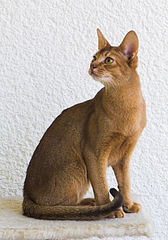

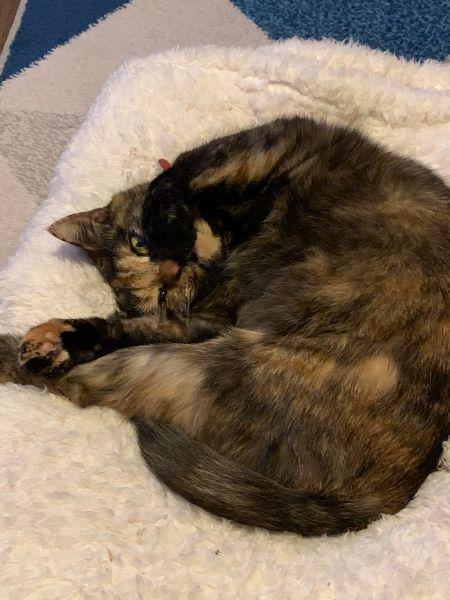

Hello print!


'Hello, world 3!'

# Hello, world!

<IPython.core.display.Latex object>

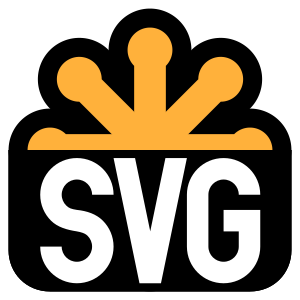

Hello!


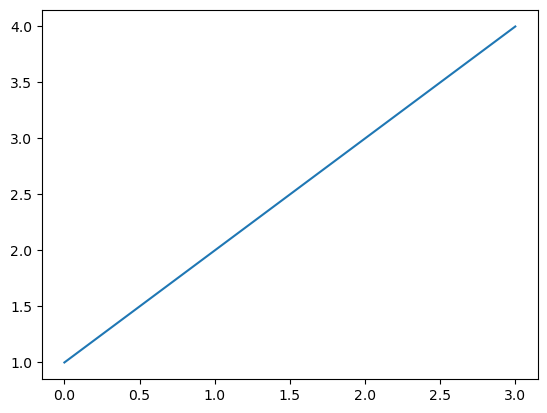

In [ ]:
#| eval: false

from matplotlib import pyplot as plt
from IPython.display import display, HTML, Markdown, Latex, SVG
from pathlib import Path
capturer = PassthroughCapturer()
capturer.start()
image = Image.open("cat.jpg")
image2 = Image.open("cat2.jpg")
ttt = display(image2, display_id=True)
ttt.display(image2)
print("Hello print!")
# display(Javascript("alert('Hello, world!!')"))
ttt.update(image)
display("Hello, world 3!")
# # clear_output()

display(HTML("<h1>Hello, world!</h1>"))
display(Markdown("# Hello, world!"))
display(Latex(r"$\int_0^\infty x^2 dx$"))

display(SVG(Path("SVG_Logo.svg").read_text()))
# print("Hello, world!")
# display("Hello, world!")
# display("Hello, world 2!")

# ttt = display("Hello, world 3!", display_id=True)
# ttt.update("Hello, world 4!")

# ttt = display("Hello, world 5!", display_id=True)
# ttt.display("Hello, world 6!")

print("Hello!")

fig, ax = plt.subplots()
ax.plot([1, 2, 3, 4])
display(fig)
plt.close()

capturer.stop()

In [ ]:
#| eval: false
capturer.get_outputs()

[{'text/plain': '<PIL.PngImagePlugin.PngImageFile image mode=RGB size=168x240>',
  'image/png': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\xa8\x00\x00\x00\xf0\x08\x02\x00\x00\x00\x1b\xf4\xb8y\x00\x01\x00\x00IDATx\x01L\xfdw\xd4\xa7\xd9}\x18\xf6\xfdz\xefo\x7f\xa7\xee\xcelG\x07\x08\x91"E\xcb\x92"\xdb\x12\x15\xdbG<\x91\xe5\xe4\xe4$\x7f$\xf1\xb1\x93#[\xb6%\xc7J\x14\xcbfD\xc9\xa6\x14US\xb4$\x92V\xb3x\xc4\x06\x88\x04\x05\x90\x04\x01\x10\xc0\x02 \xdab\xeb\xec\xee\xf4\x99\xb7\xf7_\xef\xf9\xdc\xe7\x0e\xc6\xba\xfb\xee3\xf7w\x9f\xef\xfd\xf6\xdb\xcb\x93\xbe{\xf7n&\x93\xa9T*\xb3\xd9,\x97\xcb\x15\x8b\xc5^\xaf7\x9dN\x0b\x85\xd2r\xb9|\xf4\xe8\xd1\xf5\xeb\xd7\xb3\xd9\xec\xc5\xc5\xc5x<n6\x9b\xe3q\x7f\xb1XH\x01\x00~\xb1H\xcd\xe7s\x90\x12\xcb\xe5\xb2\xa7\x9f\xa5R)\x95Ju\xbb\xdd\xd1h\x94\xcb\xa5\x06\x83\x01\xf8z\xbd\x8e\x10H\xf1t:].\xd7\x0f\x0f\x0f\x11\x92\x0e^\xfap8D\xa5P(\xac\xaf\xaf\xc7\x08\x8a\x18\xf3J\xc6\\.#\x97\x148\'I\xa8V\xab\x9b\x9b\x9b\xc3\xe1\xf8\xce\x9d\xf7+\x95\x12>\xf7\xf7\x0f{\xbd\xc1

In [ ]:
#| exporti
from claudette import text_msg, img_msg

In [ ]:
#| export
def svg_to_png(svg_content, max_size):
    root = ET.fromstring(svg_content)


    def parse_dimension(value):
        if value.endswith('%'):
            return float(value[:-1]) / 100 * max_size
        return float(re.findall(r'[\d.]+', value)[0])

    width = parse_dimension(root.attrib.get('width', str(max_size)))
    height = parse_dimension(root.attrib.get('height', str(max_size)))

    viewBox = root.attrib.get('viewBox')
    if viewBox:
        _, _, vb_width, vb_height = map(float, viewBox.split())
        if width == max_size:
            width = vb_width
        if height == max_size:
            height = vb_height

    scale = min(max_size / width, max_size / height)
    new_width = int(width * scale)
    new_height = int(height * scale)

    # Render PNG
    png =  cairosvg.svg2png(bytestring=svg_content, output_width=new_width, output_height=new_height)
    return png

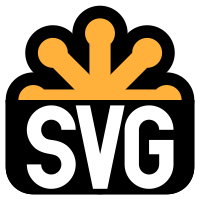

In [ ]:
#| eval: false
Image.open(BytesIO(svg_to_png(Path("SVG_Logo.svg").read_text(), 200)))

In [ ]:
#| export

def display_to_messages(dsp):
    plain_text = dsp.get("text/plain")
    text = list(filter(lambda x:x[1], [
        ("text-html", dsp.get("text/html")),
        ("latex", dsp.get("text/latex")),
        ("markdown", dsp.get("text/markdown")),
        ("json", dsp.get("application/json")),
        ("js", dsp.get("application/javascript"))
    ]))

    images = list(filter(lambda x:x, [ dsp.get("image/png"), dsp.get("image/jpeg") ]))
    svg = dsp.get("image/svg+xml")
    if svg: images.append(svg_to_png(svg, 256))

    messages = [f"<{t[0]}>{t[1]}</{t[0]}>" for t in text]

    if not len(messages):
        messages = [plain_text]

    claudette_msgs = [text_msg(m) for m in messages]
    if images:
        imagebytes = base64.b64decode(images[0]) if not isinstance(images[0], bytes) else images[0]
        claudette_msgs.append(img_msg(imagebytes)) # Grab only one image

    return claudette_msgs

In [ ]:
#| eval: false
for dsp in capturer.get_outputs():
    print(display_to_messages(dsp))
    print("----")

[{'type': 'text', 'text': '<PIL.PngImagePlugin.PngImageFile image mode=RGB size=168x240>'}, {'type': 'image', 'source': {'type': 'base64', 'media_type': 'image/png', 'data': 'iVBORw0KGgoAAAANSUhEUgAAAKgAAADwCAIAAAAb9Lh5AAEAAElEQVR4AUz9d9Sn2X0Y9v16729/p+7ObEcHCJEiRcuSItsSFdtHPJHl5OQkfyTxsZMjW7Ylx0oUy2ZEyaYUVVO0JJJWs3jEBogEBZAEARDAAiDaYuvs7vSZt/df7/nc5w7GuvvuM/d3n+/99tvLk757924mk6lUKrPZLJfLFYvFXq83nU4LhdJyuXz06NH169ez2ezFxcV4PG42m+Nxf7FYSAEAfrFIzedzkBLL5bKnn6VSKZVKdbvd0WiUy6UGgwH4er2OEEjxdDpdLtcPDw8Rkg5e+nA4RKVQKKyvr8cIihjzSsZcLiOXFDgnSahWq5ubm8Ph+M6d9yuVEj739w97vcHlS9dwtFiOSYQ0DJgRgRmqdrsNOaKnp6fSSXR+fg5VRJvP50khhWiRDVKIyyvgPAoITzqVS6WCLNlc+uTk6OzsLJ1etlqtdmsD/lqtdnx8jBYSFIJKt3f+7rvv3rhxAwmCQ449gWhy7e/vwymXFACehKWW3d1dFpEdD1LgrFbLlCB4S7Sn8XQ6S4EwyI7nyPDJyQl4YGwqu4BPCFdXV3Og/UYeiwICnrJFhhiGkvGBjBSEy+W8CC4lAoaFTuGlO0zAFt0CPCRkhskTEpqV+DSjlE6n46e8uCG8gBMU+/3gW3JFnEhgibLAwwAGXQHCe/fuXbp0RRwPkLCCLDKen3fLlSCIgE+cSJcRLVaRkXWjyJEfKbSDLq5EBGwQJ+alSjij60TGsJTNZHl7JJGYIIgIQzZzEfnBDLQ8LObFOQFxgiL8o